<a href="https://colab.research.google.com/github/adolfoguimaraes/datascience/blob/main/code/08_laboratorio_clusterizacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterização 

Para nosso exemplo de clusterização vamos trabalhar com o algortimo particional (K-Means).

## DataSet 

A base de dados escolhida para esse trabalho é a USArrests disponível [neste link](https://www.kaggle.com/deepakg/usarrests). Esse conjunto de dados contém estatísticas, em detenções por 100.000 habitantes pelos crimes de agressão, assassinato e estupro em cada um dos 50 estados dos EUA em 1973. Também é fornecida a porcentagem da população que vive em áreas urbanas.

Vamos dividir essa tarefa em três partes: 

1. Análise simples dos dados 
2. Identificação de clusters com aplicação do k-means.
3. Análise dos clusters extraídos a partir das visualização.

Vamos começar ;) 



In [1]:
# Imports necessários 

import pandas as pd 
from sklearn import preprocessing
from scipy.spatial import distance_matrix
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import plotly.graph_objects as go

Para montar a base de dados vamos precisar de dois arquivos: a base original da USArrests e uma base de estados americanos para identificar a sigla de cada estado. Vamos usar essa informação para alguns exemplos de visualização. Os arquivos podem ser acessados na pasta `datasets/clusterizacao`.

In [2]:
# Carregando a base de dados 
dataset_usa = pd.read_csv("../datasets/clusterizacao/USAArrests.csv", names=['State','Murder','Assault','Rape','UrbanPop'],skiprows=[0],index_col=['State'])
dataset_states = pd.read_csv("../datasets/clusterizacao/USAStates.csv", names=['state','code'], index_col=['state'], skiprows=[0])

In [3]:
dataset_states.head()

,code
state,
Alabama,AL
Alaska,AK
Arizona,AZ
Arkansas,AR
California,CA


In [4]:
# Juntando as duas bases
dataset_usa['Code'] = dataset_states['code']

In [5]:
# Dataframe Final 
dataset_usa.head(20)

,Murder,Assault,Rape,UrbanPop,Code
State,,,,,
Alabama,13.2,236,58,21.2,AL
Alaska,10.0,263,48,44.5,AK
Arizona,8.1,294,80,31.0,AZ
Arkansas,8.8,190,50,19.5,AR
California,9.0,276,91,40.6,CA
Colorado,7.9,204,78,38.7,CO
Connecticut,3.3,110,77,11.1,CT
Delaware,5.9,238,72,15.8,DE
Florida,15.4,335,80,31.9,FL


## Primeira Etapa: Análise simples dos dados

Nessa etapa vamos extrair apenas algumas correlações para entender a relação que existe entre os atributos. Podemos tentar responder algumas perguntas como: 

* Será que existe relação entre os crimes? 
* Será que existe correlação entre os crimes e a porcentagem da população?

Vamos analisar a matriz de correlação:

<AxesSubplot:>

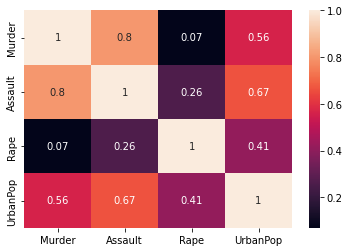

In [6]:
dataset_usa_corr = dataset_usa[['Murder','Assault','Rape', 'UrbanPop']].corr()
sns.heatmap(dataset_usa_corr, xticklabels=['Murder','Assault','Rape', 'UrbanPop'], yticklabels=['Murder','Assault','Rape', 'UrbanPop'], annot=True)

**O que podemos concluir?**

* Existe uma correlação entre os tipos de crimes e a porcentagem da população na ordem do mais correlacionado para o menos correlacionado: _Murder_, _Assault_ e _Rape_. 
* Uma outra correlação que podemos identificar é entre _Murder_ e _Assault_. 



Antes de trabalharmos com os algoritomos de clusterização vamos fazer uma rápida análise a respeito da relação de cada instância da base de dados. A idéia é exibir uma matriz de similaridade entre as instâncias com o intuito de verificar algum tipo de relação entre os estados a partir dos dados coletados. 

A similaridade é baseada na distância entre as instâncias. Como essa métrica é influenciada pela escala dos valores. Vamos normalizar alguns dados.

In [7]:
x = dataset_usa[['Murder','Assault','UrbanPop','Rape']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset_usa_norm = pd.DataFrame(x_scaled, index=dataset_usa.index, columns=['Murder','Assault','UrbanPop','Rape'])
dataset_usa_norm.head()

,Murder,Assault,UrbanPop,Rape
State,,,,
Alabama,0.746988,0.654110,0.359173,0.440678
Alaska,0.554217,0.746575,0.961240,0.271186
Arizona,0.439759,0.852740,0.612403,0.813559
Arkansas,0.481928,0.496575,0.315245,0.305085
California,0.493976,0.791096,0.860465,1.000000


In [8]:
from scipy.spatial.distance import pdist, squareform

In [10]:
dataframe_dist = pd.DataFrame(
    squareform(pdist(dataset_usa_norm[['Murder','Assault','Rape','UrbanPop']], metric='euclidean')),
    columns = dataset_usa.Code,
    index = dataset_usa.Code
)

Vamos usar essa tabela de distância para ver alguns dados específicos:

In [11]:
long_form = dataframe_dist.unstack()

long_form.index.rename(["Cidade A", "Cidade B"], inplace=True)
long_form = long_form.to_frame('distance').reset_index()

In [12]:
long_form[
    (long_form['distance'] < 0.1) 
    & (long_form['Cidade A'] != long_form['Cidade B'])
]

,Cidade A,Cidade B,distance
631,IL,NY,0.087186
728,IA,NH,0.049986
1414,NH,IA,0.049986
1562,NY,IL,0.087186


A tabela acima mostra as cidades que estão mais próximas, em outras palavras, as cidades que são mais similares a partir das informações de crimes e tamanho da população reportado. Vamos analisar dois pares de cidades: 

**IA e NH:** 

Da tabela original, temos: 

`Iowa	2.2	56	57	11.3`

`New Hampshire	2.1	57	56	9.5`

**NY e IL:** 

`New York	11.1	254	86	26.1`

`Illinois	10.4	249	83	24.0`

É fácil perceber a semelhança entre as cidades relacionadas e isso é extraído a partir da métricas de distância. 

## Segunda Parte: Algoritmos de Clusterização

Vamos aplicar dois algoritmos de clusterização: um baseado em dist

### K-Means

In [13]:
from sklearn import metrics

for k in range(2, 10):

  kmeans = KMeans(n_clusters=k)
  kmeans.fit(dataset_usa_norm[['Murder','Assault','Rape','UrbanPop']])
  score_mean = metrics.silhouette_score(dataset_usa_norm[['Murder','Assault','Rape','UrbanPop']], kmeans.labels_, metric='euclidean')
  print(k, score_mean)



2 0.42364457559625074
3 0.3187755079997931
4 0.3349095719865253
5 0.2855349404911621
6 0.2734921264686129
7 0.25702652559551475
8 0.24285091171881912
9 0.24294194671433625


In [14]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(dataset_usa_norm[['Murder','Assault','Rape','UrbanPop']])

KMeans(n_clusters=2)

In [15]:
clusters = kmeans.labels_.tolist()
clusters_dict = { 'code': list(dataset_usa.Code), 'city': dataset_usa.index, 'cluster': clusters}
dataframe_clusters = pd.DataFrame(clusters_dict, columns = ['cluster','code', 'city'])

In [16]:
dataframe_clusters

,cluster,code,city
0,0,AL,Alabama
1,0,AK,Alaska
2,0,AZ,Arizona
3,1,AR,Arkansas
4,0,CA,California
5,0,CO,Colorado
6,1,CT,Connecticut
7,1,DE,Delaware
8,0,FL,Florida
9,0,GA,Georgia


## Visualização

### K-Means

In [29]:
fig = go.Figure(data=go.Choropleth(
    locations=dataframe_clusters['code'], # Spatial coordinates
    z = dataframe_clusters['cluster'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'blugrn',
    colorbar_title = "Cluster",
))

fig.update_layout(
    title_text = 'Clusterização de Regiões - KMeans',
    geo_scope='usa', # limite map scope to USA
)

fig.show()